In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 
sns.set()

list_of_columns = [
 'home',
 'away',
 'date',
 'venue',
 'league',
 'part_of_competition',
 'home_score',
 'away_score',
 'home_possessionPct',
 'away_possessionPct',
 'home_shotsSummary',
 'away_shotsSummary',
 'home_foulsCommitted',
 'away_foulsCommitted',
 'home_yellowCards',
 'away_yellowCards',
 'home_redCards',
 'away_redCards',
 'home_offsides',
 'away_offsides',
 'home_wonCorners',
 'away_wonCorners',
 'home_saves',
 'away_saves'
]

def strip_perc_symbol(perc):
    return float(perc.strip('%'))

def shots(shot_summary):
    interm_string = shot_summary.strip(')')
    entries = interm_string.split('(')
    return int(entries[0])

def shots_on_goal(shot_summary):
    interm_string = shot_summary.strip(')')
    entries = interm_string.split('(')
    return int(entries[1])


from sklearn.base import BaseEstimator, TransformerMixin
class FeaturesSubsetter(BaseEstimator, TransformerMixin):
    def __init__(self, subset=True):
        self.subset=subset
    def fit(self, X, y=None):
        return self 
    def transform(self, X):
        if self.subset:
            return X.loc[:, list_of_columns]
        else:
            return X 

class NaDropper(BaseEstimator, TransformerMixin):
    def __init__(self, format=True):
        self.format=format
    def fit(self, X, y=None):
        return self 
    def transform(self, X):
        return X.dropna() 


class PctFormatter(BaseEstimator, TransformerMixin):
    def __init__(self, format=True):
        self.format=format
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.format:
            X['home_possessionPct'] = X['home_possessionPct'].apply(strip_perc_symbol)
            X['away_possessionPct'] = X['away_possessionPct'].apply(strip_perc_symbol)

        return X

class SummaryFormatter(BaseEstimator, TransformerMixin):
    def __init__(self, format=True):
        self.format=format
    def fit(self, X, y=None):
        return self 
    def transform(self, X):
        if self.format:
            X['home_shots'] = X['home_shotsSummary'].apply(shots)
            X['home_shots_on_goal'] = X['home_shotsSummary'].apply(shots_on_goal)
            X = X.drop('home_shotsSummary', axis=1)

            X['away_shots'] = X['away_shotsSummary'].apply(shots)
            X['away_shots_on_goal'] = X['away_shotsSummary'].apply(shots_on_goal)
            X = X.drop('away_shotsSummary', axis=1)

        return X


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

pipeline = Pipeline([
    ('subsetter', FeaturesSubsetter()), 
    ('na_dropper', NaDropper()),
    ('pct_formatter', PctFormatter()), 
    ('summary_formatter', SummaryFormatter())
])
      

num_attribs = [
 'home_possessionPct',
 'away_possessionPct',
 'home_foulsCommitted',
 'away_foulsCommitted',
 'home_yellowCards',
 'away_yellowCards',
 'home_redCards',
 'away_redCards',
 'home_offsides',
 'away_offsides',
 'home_wonCorners',
 'away_wonCorners',
 'home_saves',
 'away_saves', 
 'home_shots',
 'home_shots_on_goal',
 'away_shots',
 'away_shots_on_goal'
]

cat_attribs = [
 'home',
 'away',
 'league'
]



from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

column_transf = ColumnTransformer([
 ("cat", OneHotEncoder(), cat_attribs),
 ("num", StandardScaler(), num_attribs)
 ])



In [3]:
# full_pipeline = Pipeline([
#     ('pipe', pipeline) ,
#     ('col_tr', column_transf)         
# ])
df = pd.read_csv('matches.csv')
df = pipeline.fit_transform(df)
y_1 = df['home_score']
y_2 = df['away_score']
df.drop(['home_score', 'away_score'], axis=1, inplace=True)
matrix = column_transf.fit_transform(df).toarray()


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (11,14,50,102,123,125,129,131,133,135,137,139,141,143,145,147,149,157,158,160,161,163,165,167,169,171,173,184,186,187,205,206) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(matrix, y_1, test_size=0.2)

In [19]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def eval_clf(clf):
    y_train_pred = cross_val_predict(clf, X_train, y_train, cv=3)
    conf_mx = confusion_matrix(y_train, y_train_pred)
    row_sums = conf_mx.sum(axis=1, keepdims=True)
    norm_conf_mx = conf_mx / row_sums
    np.fill_diagonal(norm_conf_mx, 0)
    plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
    plt.colorbar()

    print("accuracy:", accuracy_score(y_train, y_train_pred))
  

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

accuracy: 0.8271052631578948


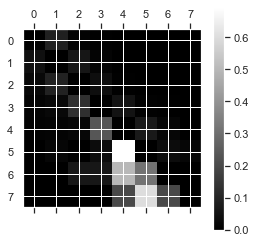

In [20]:
from sklearn.linear_model import LogisticRegression

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10)
softmax_reg.fit(X_train, y_train)

eval_clf(softmax_reg)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


accuracy: 0.4284210526315789


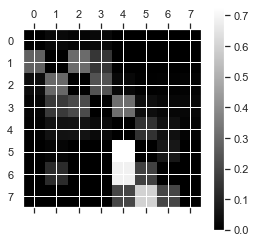

In [21]:
from sklearn.svm import LinearSVC

linsvc = LinearSVC(C=10, loss="hinge")
linsvc.fit(X_train, y_train)

eval_clf(linsvc)

In [8]:
# from sklearn.preprocessing import PolynomialFeatures

# polynomial_svm_clf = Pipeline([
#  ("poly_features", PolynomialFeatures(degree=3)),
#  ("scaler", StandardScaler()),
#  ("svm_clf", LinearSVC(C=10, loss="hinge"))
#  ])

# polynomial_svm_clf.fit(X_train, y_train)
# eval_clf(polynomial_svm_clf)

accuracy: 0.7905263157894736


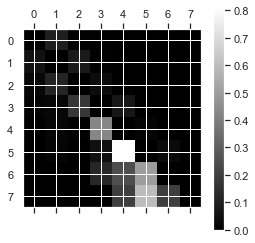

In [22]:
from sklearn.svm import SVC
svc_poly = SVC(kernel='poly', degree=3, coef0=1, C=1)
svc_poly.fit(X_train, y_train)

eval_clf(svc_poly)

accuracy: 0.30526315789473685


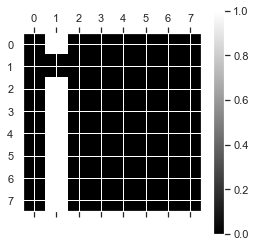

In [32]:
rbf_kernel_svm_clf = SVC(kernel='rbf', gamma=5, C=0.0000001)
rbf_kernel_svm_clf.fit(X_train, y_train)
eval_clf(rbf_kernel_svm_clf)

accuracy: 0.3707894736842105


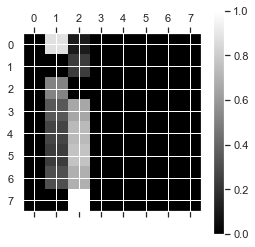

In [25]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=300, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

eval_clf(rnd_clf)

accuracy: 0.1568421052631579


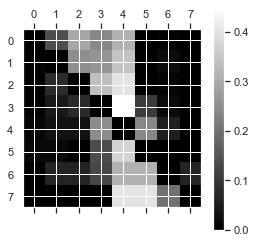

In [26]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
 DecisionTreeClassifier(max_depth=1), n_estimators=200,
 algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)

eval_clf(ada_clf)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

accuracy: 0.8065789473684211


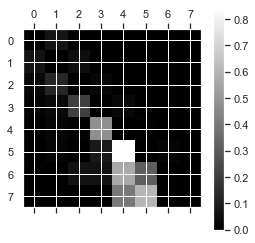

In [27]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
 estimators=[('lr', softmax_reg), ('svc', svc_poly)],
 voting='hard')
voting_clf.fit(X_train, y_train)

eval_clf(voting_clf)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 1068, in f1_score
    return fbeta_score(y_

accuracy: 0.3318421052631579


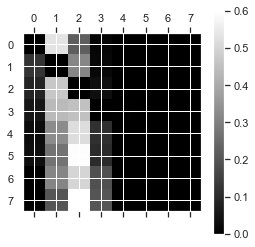

In [29]:
from sklearn.model_selection import GridSearchCV
param_grid = [
 {'n_estimators': [30, 100, 300], 'max_features': [2, 4, 6, 8]},
 {'bootstrap': [False], 'n_estimators': [30, 100], 'max_features': [2, 3, 4]},
 ]
forest_clf = RandomForestClassifier()
grid_search = GridSearchCV(forest_clf, param_grid, cv=5,
 scoring='f1',
return_train_score=True)
grid_search.fit(X_train, y_train)

eval_clf(grid_search.best_estimator_)

## Tuning parameters 

accuracy: 0.8713157894736843


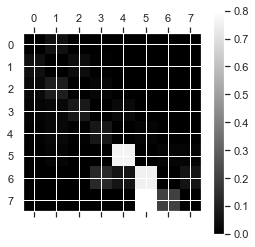

In [60]:
param_grid = [
 {'degree': [2,3,4], 'coef0': [50, 100], 'C':[0.00001, 0.0001, 0.001]}
 ]
svc_poly_grid = SVC(kernel='poly', degree=3, coef0=1, C=1)
svc_poly_grid_search = GridSearchCV(svc_poly_grid, param_grid, cv=3,
 scoring='accuracy')
svc_poly_grid_search.fit(X_train, y_train)

eval_clf(svc_poly_grid_search.best_estimator_)

In [47]:
grid_search.best_params_

{'C': 0.001, 'coef0': 50, 'degree': 3}

accuracy: 0.871578947368421


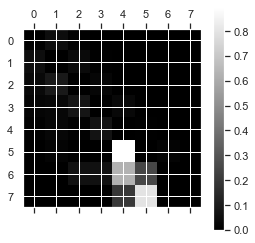

In [61]:
param_grid = [
 {'gamma': [0.00001, 0.0001, 0.001], 'C':[ 100, 1000, 10000]}
 ]
rbf_kernel_svm_clf_grid = SVC(kernel='rbf')
rbf_kernel_svm_clf_grid_search = GridSearchCV(rbf_kernel_svm_clf_grid, param_grid, cv=3,
 scoring='accuracy')
rbf_kernel_svm_clf_grid_search.fit(X_train, y_train)

eval_clf(rbf_kernel_svm_clf_grid_search.best_estimator_)

In [40]:
grid_search.best_params_

{'C': 1000, 'gamma': 0.0001}

accuracy: 0.4797368421052632


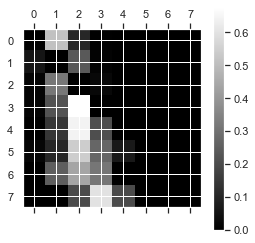

In [62]:
param_grid = [
 {'n_estimators': [ 150, 200, 500], 'max_leaf_nodes':[ 200, 300, 500 ]}
 ]
rnd_clf_grid = RandomForestClassifier()
rnd_clf_grid_search = GridSearchCV(rnd_clf_grid, param_grid, cv=3,
 scoring='accuracy')
rnd_clf_grid_search.fit(X_train, y_train)

eval_clf(rnd_clf_grid_search.best_estimator_)

In [58]:
grid_search.best_params_

{'max_leaf_nodes': 200, 'n_estimators': 150}

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

accuracy: 0.8336842105263158


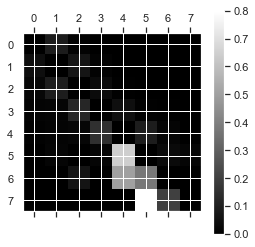

In [63]:
param_grid = [
 {'C': [100, 500, 1000, 5000]}
 ]
softmax_reg_grid = LogisticRegression(multi_class="multinomial",solver="lbfgs")
softmax_reg_grid_search = GridSearchCV(softmax_reg_grid, param_grid, cv=3,
 scoring='accuracy')
softmax_reg_grid_search.fit(X_train, y_train)

eval_clf(softmax_reg_grid_search.best_estimator_)

In [53]:
grid_search.best_params_

{'C': 100}

## Finally, the voter ensemble 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

accuracy: 0.87


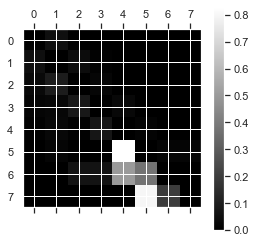

In [64]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
 estimators=[('svc', svc_poly_grid_search.best_estimator_), 
 ('rbf', rbf_kernel_svm_clf_grid_search.best_estimator_), 
 ('sref', softmax_reg_grid_search.best_estimator_)
 ],
 voting='hard')
voting_clf.fit(X_train, y_train)

eval_clf(voting_clf)